# Feature engineering

An online merchant asks you to make real-time predictions for the customers of his 
website: when they are ready to buy, tell them the date of receipt of their product, for 
the various possible transport services.

To do this, you have 6 weeks of order history with 3 pieces of information
- Date and time of the customer's order
- Shipment date (to simplify considered as order shipment date)
- Transport service
In production
- You will have a daily update (every night) of the warehouse status (this same updated 
file)
- You will need to be able to deliver real-time on-the-fly prediction with each new online 
order. The speed of your predictive model will be as important as its accuracy

## Data visualisation

### Data import

In [1]:
# import librairies and dataset
import pandas as pd
import matplotlib.pyplot as plt
import datetime

dataset = pd.read_csv('./datasets/logistique.csv')
dataset

,datedecreationdecommande,providerservice_id,dateexpe
0,2019-11-01 11:40:35.9930000,48,02/11/2019
1,2019-11-01 11:40:35.9700000,48,02/11/2019
2,2019-11-01 10:24:40.8930000,48,02/11/2019
3,2019-11-01 14:24:21.1770000,48,02/11/2019
4,2019-11-01 13:28:35.7900000,48,02/11/2019
...,...,...,...
572836,2019-12-16 06:12:25.2170000,48,17/12/2019
572837,2019-12-16 06:12:25.4630000,48,17/12/2019
572838,2019-12-15 22:32:36.3200000,48,17/12/2019
572839,2019-12-15 20:06:55.0670000,48,17/12/2019


In [2]:
dataset.dtypes

datedecreationdecommande    object
providerservice_id           int64
dateexpe                    object
dtype: object

### Data cleaning

In [3]:
# Seperate date and time of creation date
order_fulldate = pd.to_datetime(dataset['datedecreationdecommande'], format='%Y-%m-%d')
order_date = order_fulldate.dt.date.astype('datetime64')
order_time = order_fulldate.dt.floor('H').astype('datetime64').dt.time

In [4]:
# Format expedition date 
expedition_date = pd.to_datetime(dataset['dateexpe'], format='%d/%m/%Y').astype('datetime64')
expedition_date

0        2019-11-02
1        2019-11-02
2        2019-11-02
3        2019-11-02
4        2019-11-02
            ...    
572836   2019-12-17
572837   2019-12-17
572838   2019-12-17
572839   2019-12-17
572840   2019-12-17
Name: dateexpe, Length: 572841, dtype: datetime64[ns]

In [5]:
# Creating a new dataframe with desired values 

df = pd.DataFrame(columns=[
    'provider_id', 
    'order_date',
    'order_time', 
    'order_stock', 
    'expedition_date', 
    'delay'])

df['provider_id'] = dataset['providerservice_id'].astype('category')
df['order_date'] = order_date
df['order_time'] = order_time
df['expedition_date'] = expedition_date
df['delay'] = (df['expedition_date'] - df['order_date']).astype('timedelta64[D]')
df['order_stock'] = df.groupby('order_date')['order_date'].transform('size')

In [6]:
df

,provider_id,order_date,order_time,order_stock,expedition_date,delay
0,48,2019-11-01,11:00:00,2641,2019-11-02,1.0
1,48,2019-11-01,11:00:00,2641,2019-11-02,1.0
2,48,2019-11-01,10:00:00,2641,2019-11-02,1.0
3,48,2019-11-01,14:00:00,2641,2019-11-02,1.0
4,48,2019-11-01,13:00:00,2641,2019-11-02,1.0
...,...,...,...,...,...,...
572836,48,2019-12-16,06:00:00,1286,2019-12-17,1.0
572837,48,2019-12-16,06:00:00,1286,2019-12-17,1.0
572838,48,2019-12-15,22:00:00,12223,2019-12-17,2.0
572839,48,2019-12-15,20:00:00,12223,2019-12-17,2.0


In [7]:
df = df[df['delay'] >= 0]
df

,provider_id,order_date,order_time,order_stock,expedition_date,delay
0,48,2019-11-01,11:00:00,2641,2019-11-02,1.0
1,48,2019-11-01,11:00:00,2641,2019-11-02,1.0
2,48,2019-11-01,10:00:00,2641,2019-11-02,1.0
3,48,2019-11-01,14:00:00,2641,2019-11-02,1.0
4,48,2019-11-01,13:00:00,2641,2019-11-02,1.0
...,...,...,...,...,...,...
572836,48,2019-12-16,06:00:00,1286,2019-12-17,1.0
572837,48,2019-12-16,06:00:00,1286,2019-12-17,1.0
572838,48,2019-12-15,22:00:00,12223,2019-12-17,2.0
572839,48,2019-12-15,20:00:00,12223,2019-12-17,2.0


### Data analysis

In [8]:
# Historique des commande : stock a traiter par date (genre le 1er octobre, le 1er novembre.... )
# Nombre de commande par provider
# Nombre de commande par date/par jour et par provider
# Heures de commandes / jour de la semaine

In [9]:
# Average delay and stock per month
df.groupby(pd.to_datetime(df['order_date']).dt.month).mean().reset_index(level=0)

,order_date,order_stock,delay
0,11,15487.550835,1.921401
1,12,21923.848840,2.882653


In [10]:
# Delay and stock evolution per day
delay_stock_evolution = df.groupby(pd.to_datetime(df['order_date'])).mean().reset_index(level=0)

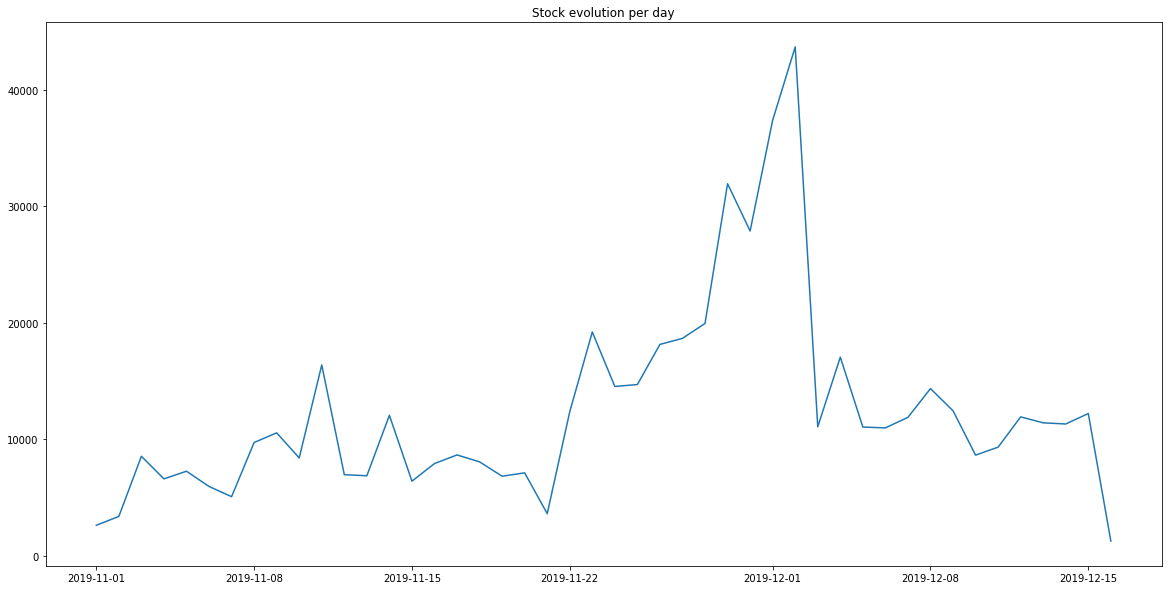

In [11]:
plt.figure(figsize=(20, 10))
plt.plot('order_date', 'order_stock', data=delay_stock_evolution)
plt.title('Stock evolution per day')
plt.show()

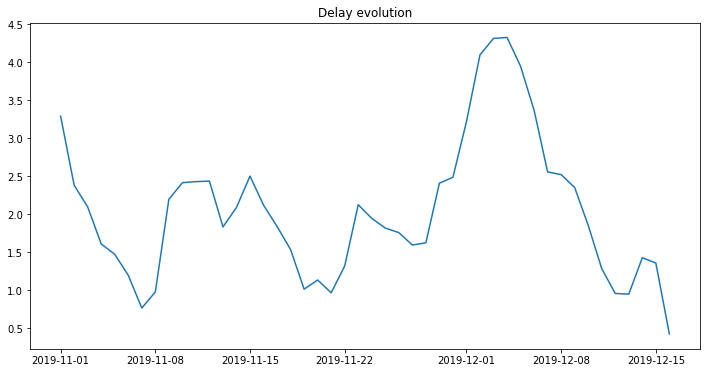

In [12]:
plt.figure(figsize=(20, 10))
plt.plot('order_date', 'delay', data=delay_stock_evolution)
plt.title('Delay evolution')
plt.show()

In [13]:
df.groupby('provider_id')['delay'].describe()[['count', 'mean', 'min', 'max']].rename(columns={'count': 'nb_deliveries', 'mean': 'mean_delay', 'min': 'min_delay', 'max': 'max_delay'})

,nb_deliveries,mean_delay,min_delay,max_delay
provider_id,,,,
5,18.0,2.888889,1.0,5.0
7,36361.0,2.998735,0.0,8.0
16,10013.0,0.678917,0.0,4.0
20,400.0,0.730000,0.0,5.0
21,75847.0,1.892890,0.0,8.0
42,5647.0,3.390827,0.0,7.0
48,442881.0,2.366358,0.0,15.0
92,1640.0,0.377439,0.0,3.0


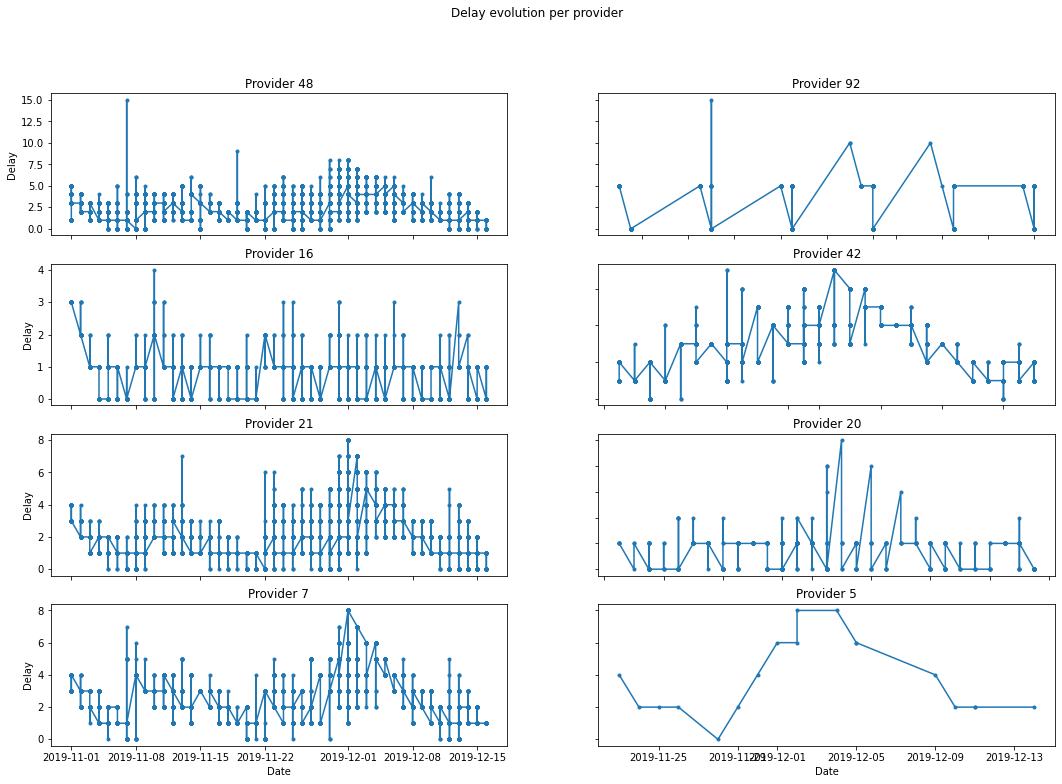

In [14]:
fig, axs = plt.subplots(4, 2)
fig.set_size_inches(18, 12)
fig.suptitle('Delay evolution per provider')

iterator = 0
for provider in df['provider_id'].unique():
    ax_x_index = iterator % 4
    ax_y_index = iterator // 4

    iterator += 1

    provider_data = df[df['provider_id'] == provider].sort_values('order_date')

    axs[ax_x_index, ax_y_index].plot('order_date', 'delay', data=provider_data, marker='.')
    axs[ax_x_index, ax_y_index].set_title(f'Provider {provider}')

for ax in axs.flat:
    ax.set(xlabel='Date', ylabel='Delay')

for ax in axs.flat:
    ax.label_outer()

#### Order hours

In [15]:
time_12 = datetime.datetime.strptime('12:00', '%H:%M').time()
time_18 = datetime.datetime.strptime('18:00', '%H:%M').time()

# Order taken before 12pm
order_before_12 = df[df['order_time'] < time_12]

# Order taken between 12pm & 6pm
order_between_12_18 = df[(df['order_time'] >= time_12) & (df['order_time'] < time_18)]

# Order taken after 6pm
order_after_18 = df[df['order_time'] >= time_18]

In [16]:
order_before_12['delay'].mean(), order_before_12['delay'].min(), order_before_12['delay'].max()

(2.0572341792003344, 0.0, 15.0)

In [17]:
order_between_12_18['delay'].mean(), order_between_12_18['delay'].min(), order_between_12_18['delay'].max()

(2.2451621513412516, 0.0, 8.0)

In [18]:
order_after_18['delay'].mean(), order_after_18['delay'].min(), order_after_18['delay'].max()

(2.5677433718262686, 0.0, 9.0)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=e4a7d48e-7d58-47a1-84ae-2aa4b9c77080' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>